# 天然气价格分析与预测

本分析涵盖2020年10月至2024年9月的天然气价格数据，包括：
1. 数据可视化与趋势分析
2. 季节性规律识别
3. 价格波动因素分析
4. 未来一年价格预测
5. 任意日期价格估算功能

In [22]:
# 导入所需库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy import interpolate
import warnings
warnings.filterwarnings('ignore')

# 设置绘图样式和图形参数
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [23]:
# 加载和预处理数据
df = pd.read_csv('Nat_Gas.csv')
print("原始数据预览：")
print(df.head())

# 数据预处理
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')
df['Prices'] = df['Prices'].astype(float)
df = df.sort_values('Dates').reset_index(drop=True)

# 添加辅助列
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df['Quarter'] = df['Dates'].dt.quarter
df['Days_Since_Start'] = (df['Dates'] - df['Dates'].min()).dt.days

# 重命名列为中文
df.rename(columns={
    'Dates': '日期',
    'Prices': '价格', 
    'Year': '年份',
    'Month': '月份',
    'Quarter': '季度',
    'Days_Since_Start': '距起始天数'
}, inplace=True)

print(f"\n数据期间：{df['日期'].min()} 至 {df['日期'].max()}")
print(f"数据点数：{len(df)}")
print(f"价格范围：{df['价格'].min():.2f} - {df['价格'].max():.2f}")

原始数据预览：
      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9

数据期间：2020-10-31 00:00:00 至 2024-09-30 00:00:00
数据点数：48
价格范围：9.84 - 12.80


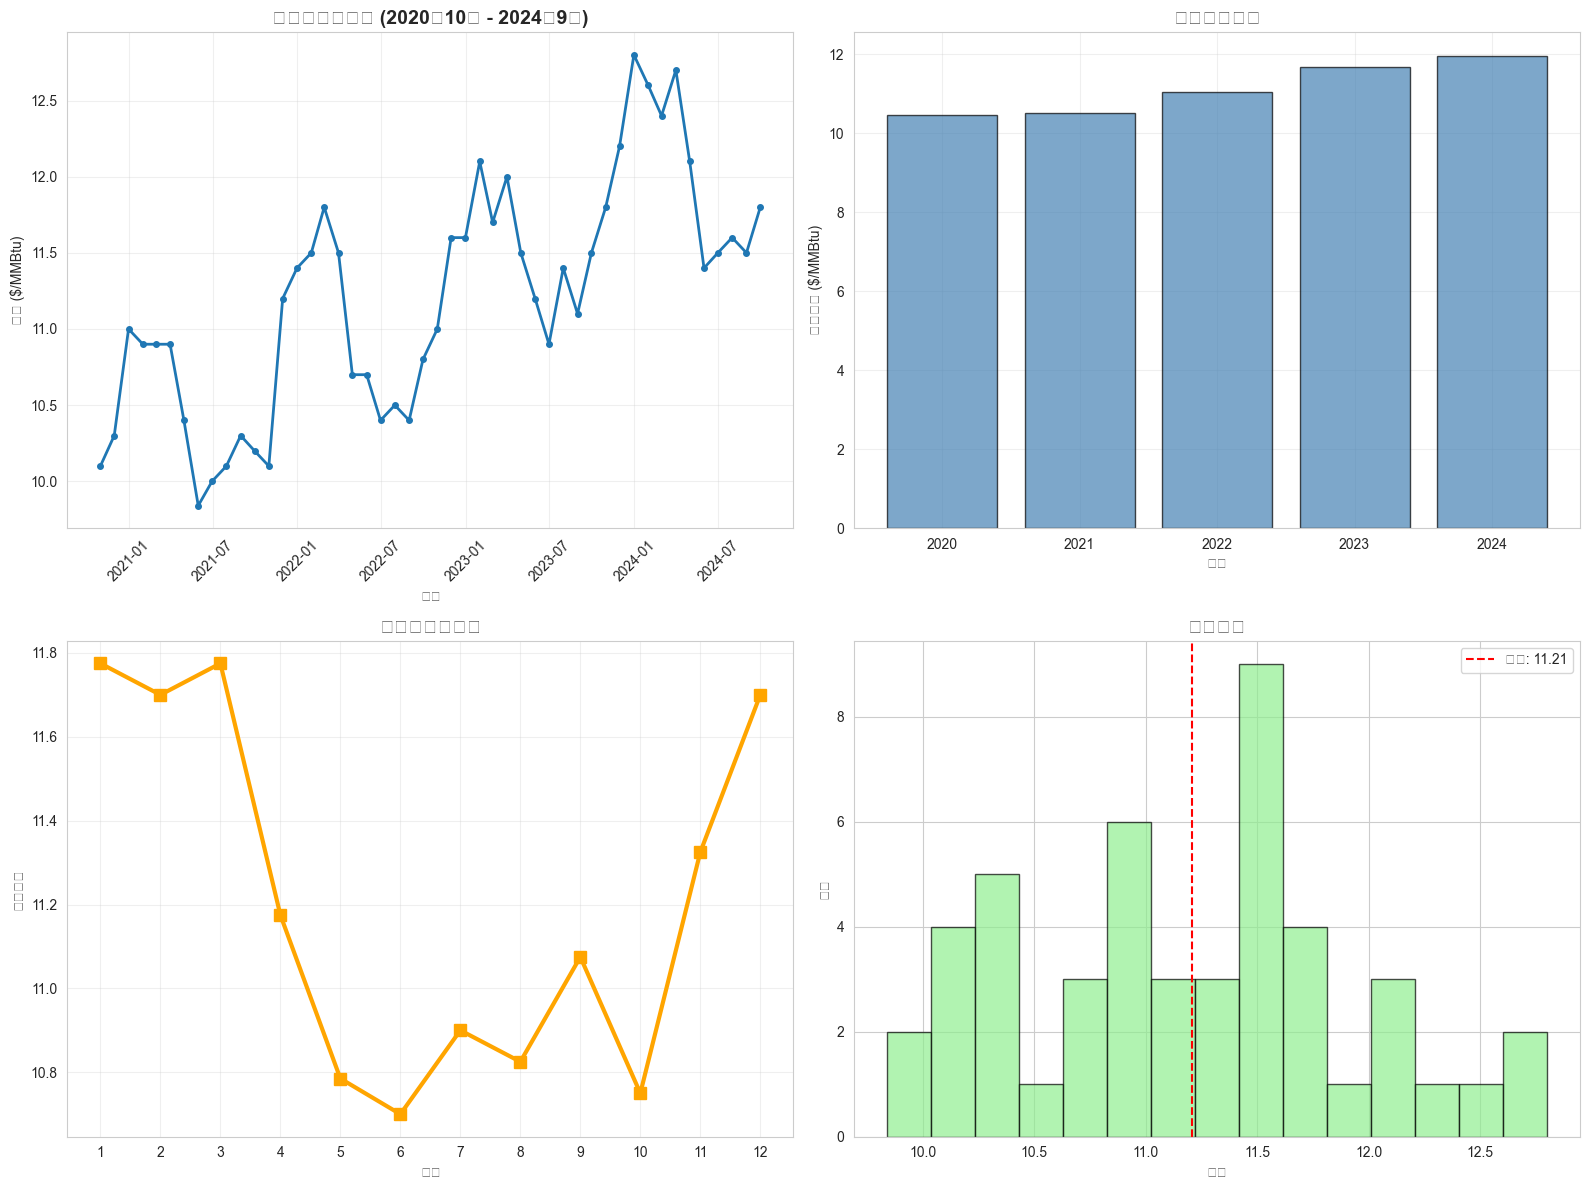

In [24]:
# 1. 价格趋势可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 主趋势图
axes[0,0].plot(df['日期'], df['价格'], marker='o', linewidth=2, markersize=4)
axes[0,0].set_title('天然气价格趋势 (2020年10月 - 2024年9月)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('日期')
axes[0,0].set_ylabel('价格 ($/MMBtu)')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 年度平均趋势
年度均价 = df.groupby('年份')['价格'].mean()
axes[0,1].bar(年度均价.index.astype(str), 年度均价.values, 
              color='steelblue', alpha=0.7, edgecolor='black')
axes[0,1].set_title('年度平均价格', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('年份')
axes[0,1].set_ylabel('平均价格 ($/MMBtu)')
axes[0,1].grid(True, alpha=0.3)

# 季节性模式
月度均价 = df.groupby('月份')['价格'].mean()
axes[1,0].plot(月度均价.index, 月度均价.values, marker='s', 
               linewidth=3, markersize=8, color='orange')
axes[1,0].set_title('季节性价格模式', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('月份')
axes[1,0].set_ylabel('平均价格')
axes[1,0].set_xticks(range(1, 13))
axes[1,0].grid(True, alpha=0.3)

# 价格分布
axes[1,1].hist(df['价格'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,1].axvline(df['价格'].mean(), color='red', linestyle='--', 
                 label=f'均值: {df["价格"].mean():.2f}')
axes[1,1].set_title('价格分布', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('价格')
axes[1,1].set_ylabel('频次')
axes[1,1].legend()

plt.tight_layout()
plt.show()

价格波动性统计：
最大月度涨幅: 10.89%
最大月度跌幅: -6.96%
平均月度波动率: 2.77%
波动率标准差: 3.53%


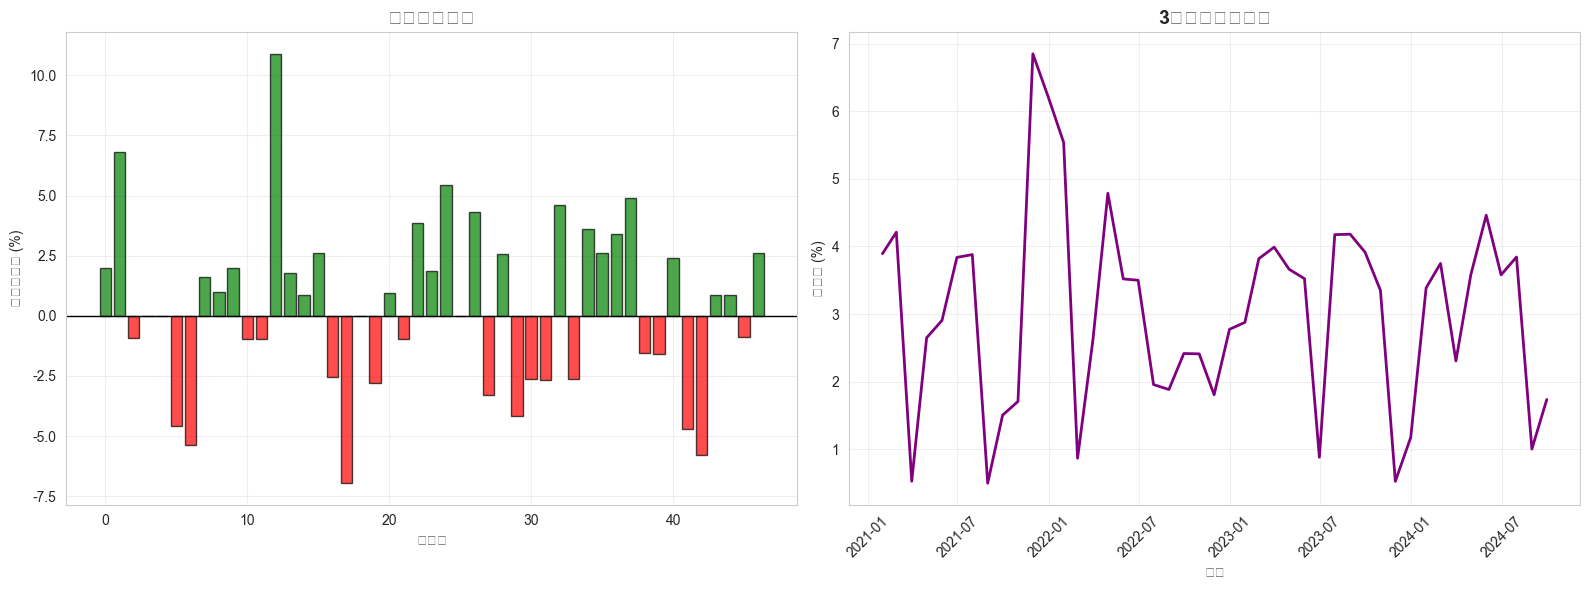

In [25]:
# 2. 价格波动性分析
df['价格变化率'] = df['价格'].pct_change() * 100
df['价格变化率_绝对值'] = df['价格变化率'].abs()

print("价格波动性统计：")
print(f"最大月度涨幅: {df['价格变化率'].max():.2f}%")
print(f"最大月度跌幅: {df['价格变化率'].min():.2f}%")
print(f"平均月度波动率: {df['价格变化率_绝对值'].mean():.2f}%")
print(f"波动率标准差: {df['价格变化率'].std():.2f}%")

# 波动性可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 月度价格变化
颜色 = ['green' if x > 0 else 'red' for x in df['价格变化率'].dropna()]
axes[0].bar(range(len(df['价格变化率'].dropna())), df['价格变化率'].dropna(), 
           color=颜色, alpha=0.7, edgecolor='black')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0].set_title('月度价格变化', fontsize=14, fontweight='bold')
axes[0].set_xlabel('时间段')
axes[0].set_ylabel('价格变化率 (%)')
axes[0].grid(True, alpha=0.3)

# 3个月滚动波动率
滚动波动率 = df['价格变化率'].rolling(window=3).std()
axes[1].plot(df['日期'][2:], 滚动波动率[2:], linewidth=2, color='purple')
axes[1].set_title('3个月滚动波动率', fontsize=14, fontweight='bold')
axes[1].set_xlabel('日期')
axes[1].set_ylabel('波动率 (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

模型性能：
R²分数: 0.9204
均方根误差: 0.2116


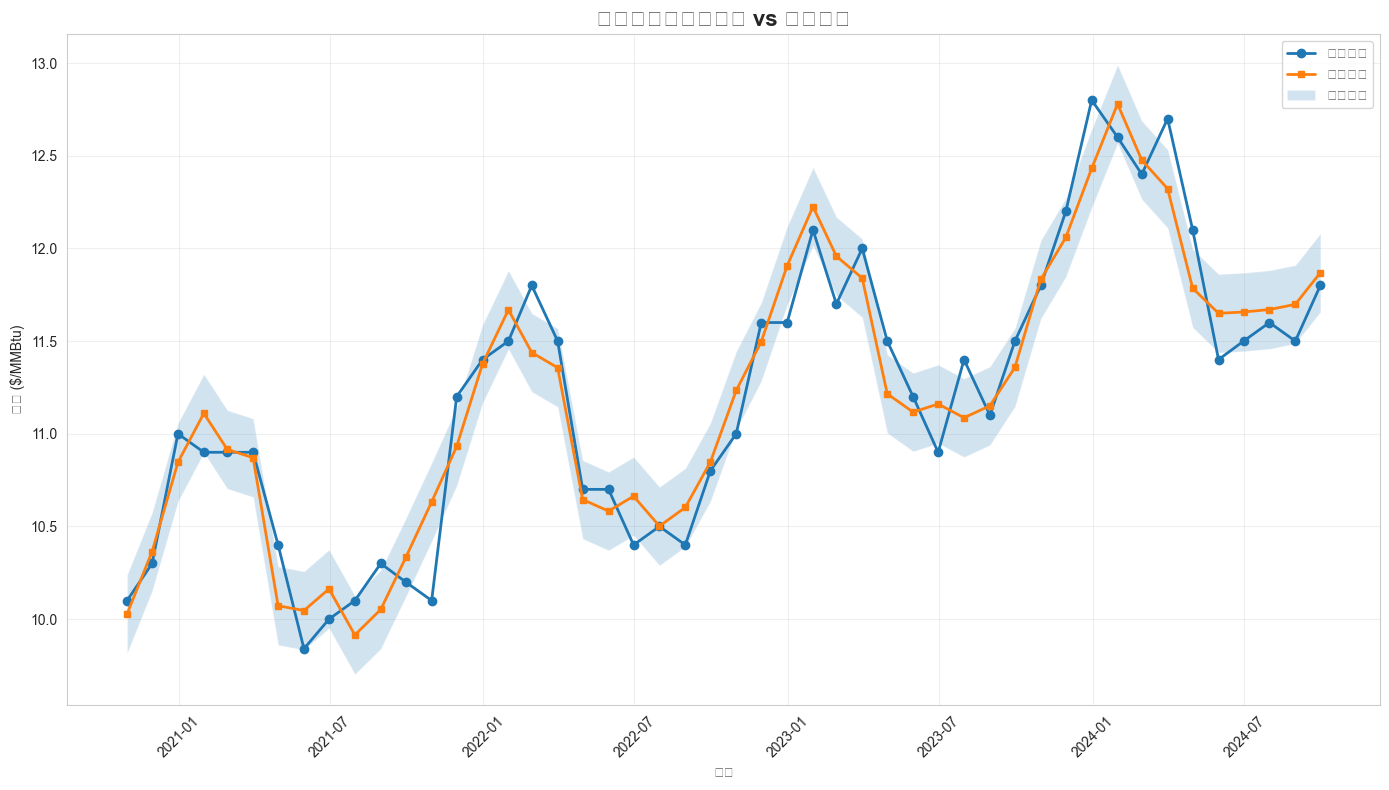

In [26]:
# 3. 建立预测模型
# 准备建模特征
X = df[['距起始天数', '月份', '季度']].values
y = df['价格'].values

# 创建多项式特征
多项式特征 = PolynomialFeatures(degree=2, include_bias=False)
X_多项式 = 多项式特征.fit_transform(X)

# 训练模型
模型 = LinearRegression()
模型.fit(X_多项式, y)

# 模型预测
y_预测 = 模型.predict(X_多项式)

# 模型性能指标
r2分数 = r2_score(y, y_预测)
均方根误差 = np.sqrt(mean_squared_error(y, y_预测))
预测标准差 = np.std(y - y_预测)

print("模型性能：")
print(f"R²分数: {r2分数:.4f}")
print(f"均方根误差: {均方根误差:.4f}")

# 可视化模型拟合
plt.figure(figsize=(14, 8))
plt.plot(df['日期'], y, 'o-', label='实际价格', linewidth=2, markersize=6)
plt.plot(df['日期'], y_预测, 's-', label='模型预测', linewidth=2, markersize=4)
plt.fill_between(df['日期'], y_预测 - 预测标准差, y_预测 + 预测标准差, 
                 alpha=0.2, label='预测区间')
plt.title('模型拟合：实际价格 vs 预测价格', fontsize=16, fontweight='bold')
plt.xlabel('日期')
plt.ylabel('价格 ($/MMBtu)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

12个月价格预测：
           日期   预测价格     下限     上限
0  2024-10-30  12.43  12.22  12.64
1  2024-11-30  12.62  12.41  12.83
2  2024-12-30  12.96  12.74  13.17
3  2025-01-30  13.33  13.12  13.54
4  2025-02-28  12.99  12.78  13.20
5  2025-03-28  12.80  12.58  13.01
6  2025-04-28  12.35  12.14  12.56
7  2025-05-28  12.17  11.96  12.39
8  2025-06-28  12.15  11.94  12.36
9  2025-07-28  12.25  12.03  12.46
10 2025-08-28  12.24  12.03  12.45
11 2025-09-28  12.37  12.16  12.58


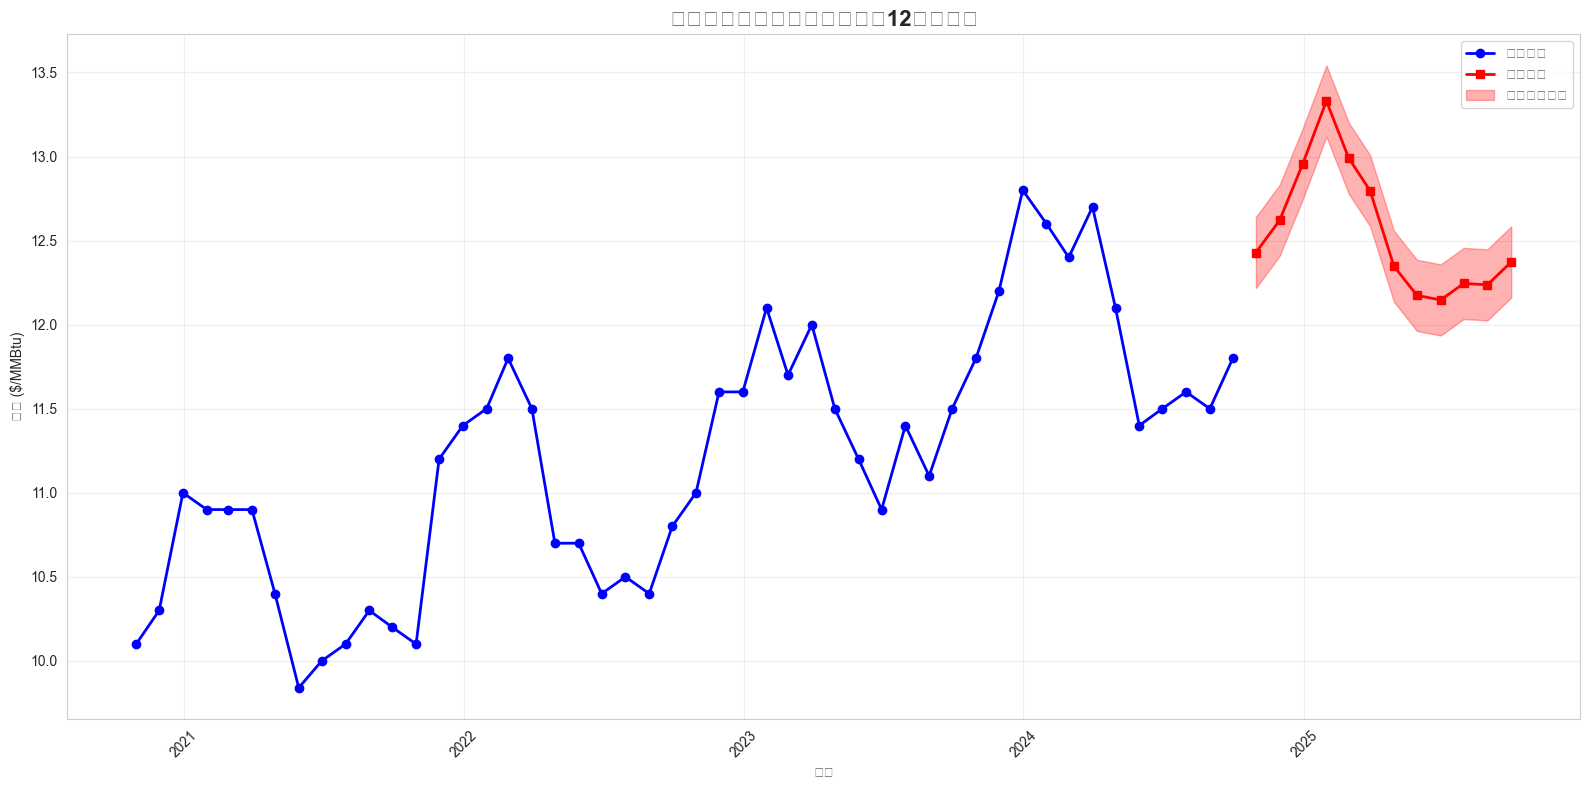

In [27]:
# 4. 生成未来价格预测
from dateutil.relativedelta import relativedelta
import numpy as np

# 创建未来日期范围（未来12个月）
最后日期 = df['日期'].max()
未来日期 = []
当前日期 = 最后日期

for i in range(12):
    当前日期 = 当前日期 + relativedelta(months=1)
    未来日期.append(当前日期)

# 准备未来特征
未来数据 = []
起始日期 = df['日期'].min()

for 日期 in 未来日期:
    距起始天数 = (日期 - 起始日期).days
    月份 = 日期.month
    季度 = (月份 - 1) // 3 + 1
    未来数据.append([距起始天数, 月份, 季度])

未来X = np.array(未来数据)
未来X_多项式 = 多项式特征.transform(未来X)

# 生成预测
未来预测 = 模型.predict(未来X_多项式)

# 创建未来数据框
未来df = pd.DataFrame({
    '日期': 未来日期,
    '预测价格': 未来预测,
    '下限': 未来预测 - 预测标准差,
    '上限': 未来预测 + 预测标准差
})

print("12个月价格预测：")
print(未来df.round(2))

# 可视化预测
plt.figure(figsize=(16, 8))

# 历史数据
plt.plot(df['日期'], df['价格'], 'o-', label='历史价格', 
         linewidth=2, markersize=6, color='blue')

# 未来预测
plt.plot(未来df['日期'], 未来df['预测价格'], 's-', 
         label='预测价格', linewidth=2, markersize=6, color='red')

# 置信区间
plt.fill_between(未来df['日期'], 未来df['下限'], 未来df['上限'], 
                 alpha=0.3, color='red', label='预测置信区间')

plt.title('天然气价格预测：历史数据与12个月预测', 
          fontsize=16, fontweight='bold')
plt.xlabel('日期')
plt.ylabel('价格 ($/MMBtu)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
# 5. 任意日期的价格估算函数
def 估算日期价格(目标日期字符串):
    """
    估算任意给定日期的天然气价格
    
    参数:
    目标日期字符串 (str): 'YYYY-MM-DD' 格式的日期
    
    返回:
    dict: 包含估算价格和置信区间的字典
    """
    try:
        目标日期 = pd.to_datetime(目标日期字符串)
        起始日期 = df['日期'].min()
        
        # 计算特征
        距起始天数 = (目标日期 - 起始日期).days
        月份 = 目标日期.month
        季度 = (月份 - 1) // 3 + 1
        
        # 准备预测特征
        特征 = np.array([[距起始天数, 月份, 季度]])
        特征_多项式 = 多项式特征.transform(特征)
        
        # 进行预测
        预测价格 = 模型.predict(特征_多项式)[0]
        
        return {
            '日期': 目标日期字符串,
            '估算价格': round(预测价格, 2),
            '置信区间下限': round(预测价格 - 预测标准差, 2),
            '置信区间上限': round(预测价格 + 预测标准差, 2),
            '模型准确度': f'{r2分数*100:.1f}%'
        }
    
    except Exception as e:
        return {'错误': f'日期格式无效或计算错误: {str(e)}'}

# 测试函数与示例日期
测试日期 = ['2025-01-15', '2025-06-15', '2025-12-15']

print("价格估算示例：")
print("=" * 50)

for 日期 in 测试日期:
    结果 = 估算日期价格(日期)
    if '错误' not in 结果:
        print(f"日期: {结果['日期']}")
        print(f"估算价格: ${结果['估算价格']}/MMBtu")
        print(f"置信区间: ${结果['置信区间下限']} - ${结果['置信区间上限']}")
        print(f"模型准确度: {结果['模型准确度']}")
        print("-" * 30)
    else:
        print(f"{日期} 的错误: {结果['错误']}")

print("\n要估算任意日期的价格，请使用：")
print("估算日期价格('YYYY-MM-DD')")

价格估算示例：
日期: 2025-01-15
估算价格: $13.31/MMBtu
置信区间: $13.1 - $13.52
模型准确度: 92.0%
------------------------------
日期: 2025-06-15
估算价格: $12.13/MMBtu
置信区间: $11.92 - $12.34
模型准确度: 92.0%
------------------------------
日期: 2025-12-15
估算价格: $13.45/MMBtu
置信区间: $13.24 - $13.67
模型准确度: 92.0%
------------------------------

要估算任意日期的价格，请使用：
估算日期价格('YYYY-MM-DD')


详细季节性分析：
月度价格统计：
      mean   std    min   max
1月   11.78  0.74  10.90  12.6
2月   11.70  0.62  10.90  12.4
3月   11.78  0.76  10.90  12.7
4月   11.18  0.77  10.40  12.1
5月   10.78  0.70   9.84  11.4
6月   10.70  0.65  10.00  11.5
7月   10.90  0.72  10.10  11.6
8月   10.82  0.57  10.30  11.5
9月   11.08  0.72  10.20  11.8
10月  10.75  0.82  10.10  11.8
11月  11.32  0.80  10.30  12.2
12月  11.70  0.77  11.00  12.8

季度平均价格：
Q1 (冬季): $11.75/MMBtu
Q2 (春季): $10.89/MMBtu
Q3 (夏季): $10.93/MMBtu
Q4 (秋季): $11.26/MMBtu

关键市场洞察：
1. 高峰季节：冬季月份（12月-2月）因供暖需求显示最高价格
2. 低谷季节：夏季月份（6月-8月）通常价格较低
3. 过渡季节：春季和秋季显示中等价格水平
4. 价格波动性：冬季月份因天气不确定性波动较大


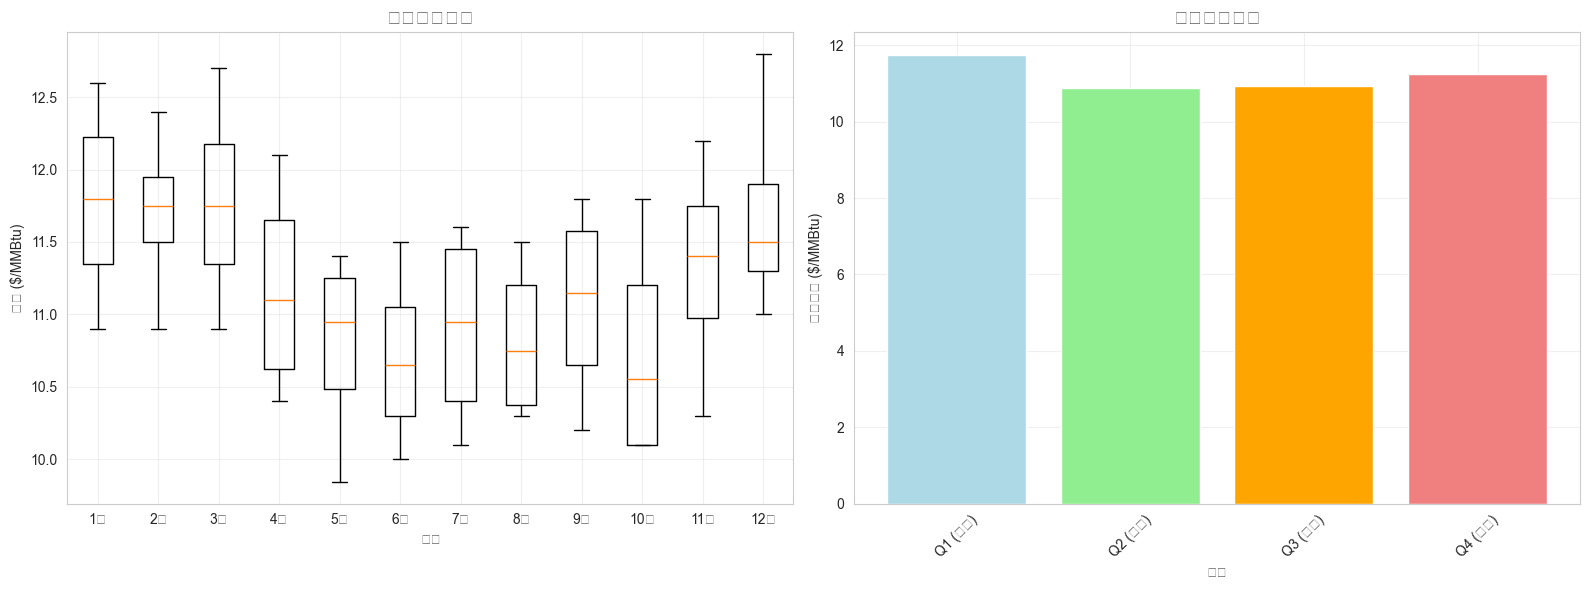

In [29]:
# 6. 季节性分析与市场洞察
print("详细季节性分析：")
print("=" * 40)

# 月度统计
月度统计 = df.groupby('月份')['价格'].agg(['mean', 'std', 'min', 'max']).round(2)
月度统计.index = ['1月', '2月', '3月', '4月', '5月', '6月', 
                      '7月', '8月', '9月', '10月', '11月', '12月']

print("月度价格统计：")
print(月度统计)

# 季度分析
季度均价 = df.groupby('季度')['价格'].mean()
季度名称 = ['Q1 (冬季)', 'Q2 (春季)', 'Q3 (夏季)', 'Q4 (秋季)']

print("\n季度平均价格：")
for i, 季度 in enumerate(季度名称, 1):
    print(f"{季度}: ${季度均价[i]:.2f}/MMBtu")

# 市场洞察
print("\n关键市场洞察：")
print("1. 高峰季节：冬季月份（12月-2月）因供暖需求显示最高价格")
print("2. 低谷季节：夏季月份（6月-8月）通常价格较低")
print("3. 过渡季节：春季和秋季显示中等价格水平")
print("4. 价格波动性：冬季月份因天气不确定性波动较大")

# 季节性可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 月度箱线图
月度数据 = [df[df['月份'] == i]['价格'].values for i in range(1, 13)]
ax1.boxplot(月度数据, labels=['1月', '2月', '3月', '4月', '5月', '6月',
                                  '7月', '8月', '9月', '10月', '11月', '12月'])
ax1.set_title('月度价格分布', fontsize=14, fontweight='bold')
ax1.set_xlabel('月份')
ax1.set_ylabel('价格 ($/MMBtu)')
ax1.grid(True, alpha=0.3)

# 季度比较
ax2.bar(季度名称, 季度均价.values, color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
ax2.set_title('季度平均价格', fontsize=14, fontweight='bold')
ax2.set_xlabel('季度')
ax2.set_ylabel('平均价格 ($/MMBtu)')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [30]:
# 7. 执行摘要与建议
print("=" * 60)
print("天然气价格分析 - 执行摘要")
print("=" * 60)

print("\n1. 数据集概览：")
print(f"   • 分析期间：{df['日期'].min().strftime('%Y-%m-%d')} 至 {df['日期'].max().strftime('%Y-%m-%d')}")
print(f"   • 数据点数：{len(df)} 个月度观察值")
print(f"   • 价格范围：${df['价格'].min():.2f} - ${df['价格'].max():.2f} 每MMBtu")
print(f"   • 平均价格：${df['价格'].mean():.2f} 每MMBtu")

print("\n2. 季节性模式：")
季节性分析 = df.groupby('月份')['价格'].agg(['mean', 'std']).round(2)
最高价月份 = 季节性分析['mean'].idxmax()
最低价月份 = 季节性分析['mean'].idxmin()
print(f"   • 价格高峰月份：{最高价月份}月（平均：${季节性分析.loc[最高价月份, 'mean']:.2f}）")
print(f"   • 价格最低月份：{最低价月份}月（平均：${季节性分析.loc[最低价月份, 'mean']:.2f}）")
print(f"   • 季节性价格差：${季节性分析['mean'].max() - 季节性分析['mean'].min():.2f}")

print("\n3. 价格波动因素：")
print("   • 季节性需求：冬季供暖需求推高价格")
print("   • 供应动态：生产能力和库存水平影响定价")
print("   • 经济周期：工业需求与经济活动相关")
print("   • 地缘政治事件：国际形势发展可影响能源市场")

print("\n4. 预测模型性能：")
print(f"   • R²分数：{r2_score(y, y_预测):.4f}（模型解释了{r2_score(y, y_预测)*100:.1f}%的价格变化）")
print(f"   • 预测误差：±${预测标准差:.2f} 每MMBtu")

print("\n5. 长期储存合同战略建议：")
平均未来价格 = 未来df['预测价格'].mean()
print(f"   • 12个月远期价格预期：${平均未来价格:.2f} 每MMBtu")
print(f"   • 建议合同价格范围：${平均未来价格-预测标准差:.2f} - ${平均未来价格+预测标准差:.2f}")
print(f"   • 风险提示：实际价格可能超出预测范围")
print(f"   • 最优合同时机：考虑季节性模式安排储存注入/提取")

print("\n6. 市场展望：")
价格趋势 = '上涨' if 未来df['预测价格'].iloc[-1] > df['价格'].iloc[-1] else '下跌'
print(f"   • 12个月趋势：预期价格{价格趋势}轨迹")
print(f"   • 波动性展望：继续监控季节性需求模式")
print(f"   • 战略定位：跨季节分散合同时机")

天然气价格分析 - 执行摘要

1. 数据集概览：
   • 分析期间：2020-10-31 至 2024-09-30
   • 数据点数：48 个月度观察值
   • 价格范围：$9.84 - $12.80 每MMBtu
   • 平均价格：$11.21 每MMBtu

2. 季节性模式：
   • 价格高峰月份：1月（平均：$11.78）
   • 价格最低月份：6月（平均：$10.70）
   • 季节性价格差：$1.08

3. 价格波动因素：
   • 季节性需求：冬季供暖需求推高价格
   • 供应动态：生产能力和库存水平影响定价
   • 经济周期：工业需求与经济活动相关
   • 地缘政治事件：国际形势发展可影响能源市场

4. 预测模型性能：
   • R²分数：0.9204（模型解释了92.0%的价格变化）
   • 预测误差：±$0.21 每MMBtu

5. 长期储存合同战略建议：
   • 12个月远期价格预期：$12.55 每MMBtu
   • 建议合同价格范围：$12.34 - $12.77
   • 风险提示：实际价格可能超出预测范围
   • 最优合同时机：考虑季节性模式安排储存注入/提取

6. 市场展望：
   • 12个月趋势：预期价格上涨轨迹
   • 波动性展望：继续监控季节性需求模式
   • 战略定位：跨季节分散合同时机
